In [1]:
import json
import os, time
import sys
sys.path.append("")
import unittest
import hashlib
import numpy as np
#install adjusted pc
from causallearn.search.ConstraintBased.PC import pc
#install pc used for comparision (could be original pc)
from causallearn.search.ConstraintBased.PC_Copy1 import pc as pc2
from causallearn.utils.cit import chisq, gsq, kci, mv_fisherz, d_separation,fisherz
from causallearn.graph.ArrowConfusion import ArrowConfusion
from causallearn.graph.AdjacencyConfusion import AdjacencyConfusion
from causallearn.graph.SHD import SHD
from causallearn.utils.DAG2CPDAG import dag2cpdag
from causallearn.utils.TXT2GeneralGraph import txt2generalgraph
from tests.utils_simulate_data import simulate_discrete_data, simulate_linear_continuous_data
from causallearn.graph.GraphClass import CausalGraph
from causallearn.graph.GeneralGraph import GeneralGraph
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.graph.GraphNode import GraphNode
from causallearn.graph.Node import Node
from causallearn.utils.GraphUtils import GraphUtils


In [2]:
np.random.seed(1)
#adjust node size
node_size = 40
reducedpctime = []
pctime = []
improvetime = []
depth = []
max_degree = []

arrow_precisions = []
arrow_recalls = []
adj_precisions = []
adj_recalls = []
arrow_precisions_Improve = []
arrow_recalls_Improve = []
adj_precisions_Improve = []
adj_recalls_Improve = []

partition_times = []
maxDegree = []
avgDegree = []
original_independence_tests = []
reduced_independence_tests = []
for itera in range(5):
    truth_DAG_directed_edges = set()
    
    edge_connection = np.zeros(node_size).astype(int)
    S, T = set(range(node_size)), set()
    # Pick a random node, and mark it as visited and the current node.
    current_node = np.random.choice(list(S), 1)[0]
    S.remove(current_node)
    T.add(current_node)

    # Create a random connected graph with maximum degree of 2.
    while S:
        # Randomly pick the next node from the neighbors of the current node.
        # As we are generating a connected graph, we assume a complete graph.
        neighbor_node = np.random.choice(node_size, 1)[0]
        while (edge_connection[neighbor_node] >= 2):
            neighbor_node = np.random.choice(node_size, 1)[0]
        # If the new node hasn't been visited, add the edge from current to new.
        if neighbor_node not in T:
            edgeset = [(current_node, neighbor_node), (neighbor_node, current_node)]
            edge = edgeset[np.random.choice(2,1)[0]]
            #edge = edgeset[0]
            truth_DAG_directed_edges.add(edge)
            S.remove(neighbor_node)
            T.add(neighbor_node)
            edge_connection[current_node]+=1
            edge_connection[neighbor_node]+=1
        # Set the new node as the current node.
        current_node = neighbor_node
    
    # Add random edges on generated 2-degree graph until the desired degree is reached.
    '''
    max_degree = 3
    for i in range(node_size):
        #k is max degree available for node i
        k = 0
        for j in range(0,node_size):
            if ((i,j) in truth_DAG_directed_edges) or ((j,i) in truth_DAG_directed_edges) or (i == j) or edge_connection[j] >= max_degree or edge_connection[i] >= max_degree:
                continue
            k+=1
        
        degree = min(k, np.random.choice(max_degree - edge_connection[i] + 1, 1)[0])
        j = np.random.choice(node_size,1)[0]
        for it in range(degree):
            while ((i,j) in truth_DAG_directed_edges) or ((j,i) in truth_DAG_directed_edges) or (i == j) or edge_connection[j] >= max_degree or edge_connection[i] >= max_degree:
                j = np.random.choice(range(0, node_size),1)[0]
            truth_DAG_directed_edges.add((i,j))
            edge_connection[i]+=1
            edge_connection[j]+=1
    '''
    

    print(len(truth_DAG_directed_edges))
    node_names = [("X%d" % (i + 1)) for i in range(node_size)]
    nodes = []
    for name in node_names:
        node = GraphNode(name)
        nodes.append(node)
    Gtrue = GeneralGraph(nodes)
    for edge in truth_DAG_directed_edges:
        Gtrue.add_directed_edge(nodes[edge[0]], nodes[edge[1]])
    data = simulate_linear_continuous_data(node_size, 10000, truth_DAG_directed_edges, "gaussian", 42)
    
    cg = pc(data, 0.01 ,fisherz, stable = False)
    endtime = time.time()
    reducedpctime.append(cg.PC_elapsed)
    #reduced_independence_tests.append(cg.independence_tests)
    
    cg2 = pc2(data, 0.01, fisherz, stable = False)
    pctime.append(cg2.PC_elapsed)
    original_independence_tests.append(cg2.independence_tests)
    improvetime.append(cg.PC_elapsed - cg2.PC_elapsed)
    #check precisions and recalls comparing to actual graph
    arrow = ArrowConfusion(Gtrue, cg.G)
    arrowsTp = arrow.get_arrows_tp()
    arrowsFp = arrow.get_arrows_fp()
    arrowsFn = arrow.get_arrows_fn()
    arrowsTn = arrow.get_arrows_tn()
    arrowPrec = arrow.get_arrows_precision()
    arrowRec = arrow.get_arrows_recall()
    arrow_precisions_Improve.append(arrowPrec)
    arrow_recalls_Improve.append(arrowRec)
    
    adj = AdjacencyConfusion(Gtrue, cg.G)

    adjTp = adj.get_adj_tp()
    adjFp = adj.get_adj_fp()
    adjFn = adj.get_adj_fn()
    adjTn = adj.get_adj_tn()

    adjPrec = adj.get_adj_precision()
    adjRec = adj.get_adj_recall()
    adj_precisions_Improve.append(adjPrec)
    adj_recalls_Improve.append(adjRec)
    
    print(adj_precisions_Improve)
    print(adj_recalls_Improve)
    
    arrow = ArrowConfusion(Gtrue, cg2.G)
    arrowsTp = arrow.get_arrows_tp()
    arrowsFp = arrow.get_arrows_fp()
    arrowsFn = arrow.get_arrows_fn()
    arrowsTn = arrow.get_arrows_tn()
    arrowPrec = arrow.get_arrows_precision()
    arrowRec = arrow.get_arrows_recall()
    arrow_precisions.append(arrowPrec)
    arrow_recalls.append(arrowRec)
    
    adj = AdjacencyConfusion(Gtrue, cg2.G)

    adjTp = adj.get_adj_tp()
    adjFp = adj.get_adj_fp()
    adjFn = adj.get_adj_fn()
    adjTn = adj.get_adj_tn()

    adjPrec = adj.get_adj_precision()
    adjRec = adj.get_adj_recall()
    
    adj_precisions.append(adjPrec)
    adj_recalls.append(adjRec)
    print(adj_precisions)
    print(adj_recalls)
print("result")
print(np.mean(np.array(reducedpctime)))
print(np.mean(np.array(pctime)))

print(np.mean(np.array(improvetime)))
print("New precision")
print(np.mean(np.array(arrow_precisions_Improve)))
print(np.mean(np.array(arrow_recalls_Improve)))
print(np.mean(np.array(adj_precisions_Improve)))
print(np.mean(np.array(adj_recalls_Improve)))
print("PC precision")
print(np.mean(np.array(arrow_precisions)))
print(np.mean(np.array(arrow_recalls)))
print(np.mean(np.array(adj_precisions)))
print(np.mean(np.array(adj_recalls)))
print("total independence tests")
print(np.mean(np.array(reduced_independence_tests)))
print(np.mean(np.array(original_independence_tests)))

39
start PC
startPC_skeleton


  0%|          | 0/40 [00:00<?, ?it/s]

Rough end 0 9
building L ended:  -0.0013282299041748047
eigen vector ended:  -0.001322031021118164
get nodes ended 0.0027167797088623047
total partition time:  0.0054171085357666016
28 32
multiprocessing start 8
start building L
Build L end:  0.0009329319000244141
eigen vector ended:  -0.001664876937866211
check ABC end:  0.0008687973022460938
start building L
Build L end:  0.0008931159973144531
eigen vector ended:  -0.0010900497436523438
check ABC end:  0.0002980232238769531
start building L
Build L end:  0.0012400150299072266
eigen vector ended:  -0.0020771026611328125
check ABC end:  0.0012731552124023438
start building L
Build L end:  0.0011339187622070312
eigen vector ended:  -0.0013360977172851562
check ABC end:  0.00043010711669921875
multiprocessing end: 2.697525978088379
merge end: 0.009132146835327148
process elapse: 3.004019021987915
ray elapse:  3.004034996032715


  0%|          | 0/40 [00:00<?, ?it/s]

epoch:  0 0.27592992782592773
independence tests: 869
epoch:  1 0.09535503387451172
independence tests: 1157
[1.0]
[1.0]
[1.0]
[1.0]
39
start PC
startPC_skeleton


/Users/zhangchilu/Desktop/Research_UCSD/causal-learn-main/causallearn/graph/ArrowConfusion.py:93: RuntimeWarning: invalid value encountered in scalar divide
  return self.__arrowsTp / (self.__arrowsTp + self.__arrowsFp)


  0%|          | 0/40 [00:00<?, ?it/s]

Rough end 0 10
building L ended:  -0.0021209716796875
eigen vector ended:  -0.0011560916900634766
get nodes ended 0.0022630691528320312
total partition time:  0.005584716796875
20 35
multiprocessing start 8
start building L
Build L end:  0.0006680488586425781
eigen vector ended:  -0.0010981559753417969
check ABC end:  0.0005791187286376953
start building L
Build L end:  0.002429962158203125
eigen vector ended:  -0.0038890838623046875
check ABC end:  0.0035550594329833984
multiprocessing end: 2.2501559257507324
merge end: 0.01034402847290039
process elapse: 2.6445538997650146
ray elapse:  2.644570827484131


  0%|          | 0/40 [00:00<?, ?it/s]

epoch:  0 0.28851819038391113
independence tests: 888
epoch:  1 0.12042021751403809
independence tests: 1267
[1.0, 1.0]
[1.0, 1.0]
[1.0, 1.0]
[1.0, 1.0]
39
start PC
startPC_skeleton


  0%|          | 0/40 [00:00<?, ?it/s]

Rough end 0 13
building L ended:  -0.0029180049896240234
eigen vector ended:  -0.0016579627990722656
get nodes ended 0.0063669681549072266
total partition time:  0.011008024215698242
28 28
multiprocessing start 8
start building L
Build L end:  0.001516103744506836
eigen vector ended:  -0.0025811195373535156
check ABC end:  0.0027947425842285156
start building L
Build L end:  0.0017657279968261719
eigen vector ended:  -0.0029566287994384766
check ABC end:  0.003353118896484375
multiprocessing end: 2.1685738563537598
merge end: 0.011179924011230469
process elapse: 2.464290142059326
ray elapse:  2.464311122894287


  0%|          | 0/40 [00:00<?, ?it/s]

epoch:  0 0.28041696548461914
independence tests: 913
epoch:  1 0.1309199333190918
independence tests: 1362
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
39
start PC
startPC_skeleton


  0%|          | 0/40 [00:00<?, ?it/s]

Rough end 0 13
building L ended:  -0.003068208694458008
eigen vector ended:  -0.0015590190887451172
get nodes ended 0.0039098262786865234
total partition time:  0.008579015731811523
22 27
multiprocessing start 8
start building L
Build L end:  0.0007169246673583984
eigen vector ended:  -0.0011398792266845703
check ABC end:  0.0006511211395263672
start building L
Build L end:  0.0018351078033447266
eigen vector ended:  -0.0031909942626953125
check ABC end:  0.003438711166381836
start building L
Build L end:  0.0008487701416015625
eigen vector ended:  -0.0010340213775634766
check ABC end:  0.0002949237823486328
multiprocessing end: 2.1788368225097656
merge end: 0.008429765701293945
process elapse: 2.4567437171936035
ray elapse:  2.4567580223083496


  0%|          | 0/40 [00:00<?, ?it/s]

epoch:  0 0.2593259811401367
independence tests: 914
epoch:  1 0.14107894897460938
independence tests: 1418
epoch:  2 0.024943828582763672
independence tests: 1421
[1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0]
39
start PC
startPC_skeleton


  0%|          | 0/40 [00:00<?, ?it/s]

Rough end 0 11
building L ended:  -0.002849102020263672
eigen vector ended:  -0.0014350414276123047
get nodes ended 0.003751993179321289
total partition time:  0.008088111877441406
27 28
multiprocessing start 8
start building L
Build L end:  0.0012581348419189453
eigen vector ended:  -0.002251148223876953
check ABC end:  0.0024149417877197266
start building L
Build L end:  0.0013875961303710938
eigen vector ended:  -0.0024225711822509766
check ABC end:  0.002905130386352539
multiprocessing end: 2.0326859951019287
merge end: 0.00906991958618164
process elapse: 2.3619890213012695
ray elapse:  2.362009286880493


  0%|          | 0/40 [00:00<?, ?it/s]

epoch:  0 0.2679097652435303
independence tests: 903
epoch:  1 0.11763286590576172
independence tests: 1301
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
result
2.5907251834869385
0.4284098148345947
2.1623153686523438
New precision
nan
0.0
1.0
1.0
PC precision
nan
0.0
1.0
1.0
total independence tests
nan
1301.6


/Users/zhangchilu/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zhangchilu/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Green: undirected; Blue: directed; Red: bi-directed



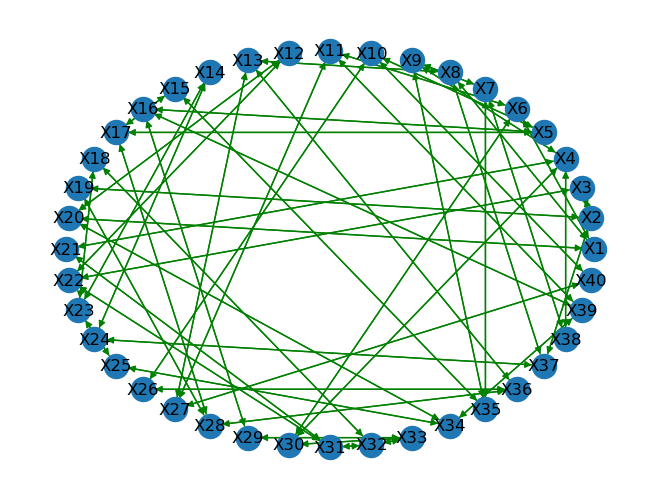

Green: undirected; Blue: directed; Red: bi-directed



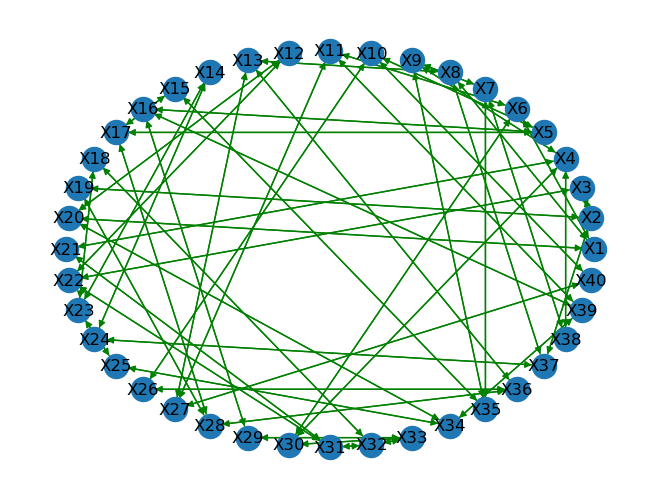

In [3]:
#turn cg graphs
cg.to_nx_graph()
cg.draw_nx_graph()
cg2.to_nx_graph()
cg2.draw_nx_graph()

55


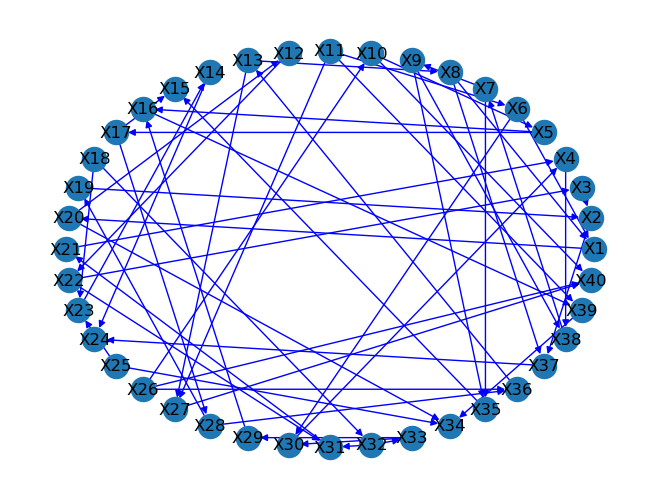

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
#show original graph
print(len(truth_DAG_directed_edges))
G=nx.DiGraph()
for i in range(10):
    G.add_node(i+1)
for pair in truth_DAG_directed_edges:
    G.add_edges_from([(pair[0]+1,pair[1]+1)])
edges = G.edges()
pos = nx.circular_layout(G)
nodes = range(len(Gtrue.graph))
labels = {i: Gtrue.nodes[i].get_name() for i in nodes}
nx_graph = nx.DiGraph()
nx_graph.add_nodes_from(nodes)
for (i, j) in truth_DAG_directed_edges:
    nx_graph.add_edge(i, j, color='b')  # Blue edge: directed edge
pos = nx.circular_layout(nx_graph)
nx.draw(nx_graph, pos=pos, with_labels=True, labels = labels , edge_color = ['b' for i in range(len(truth_DAG_directed_edges))])